In [ ]:
from google.colab import drive
drive.mount('/content/drive')


DATA_DIR = "/content/drive/MyDrive/chest_xray"
!ls -R "$DATA_DIR" | head -n 40

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/chest_xray:
chest_xray
__MACOSX
test
train
val

/content/drive/MyDrive/chest_xray/chest_xray:
test
train
val

/content/drive/MyDrive/chest_xray/chest_xray/test:
NORMAL
PNEUMONIA

/content/drive/MyDrive/chest_xray/chest_xray/test/NORMAL:
IM-0001-0001.jpeg
IM-0003-0001.jpeg
IM-0005-0001.jpeg
IM-0006-0001.jpeg
IM-0007-0001.jpeg
IM-0009-0001.jpeg
IM-0010-0001.jpeg
IM-0011-0001-0001.jpeg
IM-0011-0001-0002.jpeg
IM-0011-0001.jpeg
IM-0013-0001.jpeg
IM-0015-0001.jpeg
IM-0016-0001.jpeg
IM-0017-0001.jpeg
IM-0019-0001.jpeg
IM-0021-0001.jpeg
IM-0022-0001.jpeg
IM-0023-0001.jpeg
IM-0025-0001.jpeg
IM-0027-0001.jpeg
IM-0028-0001.jpeg
IM-0029-0001.jpeg
IM-0030-0001.jpeg


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm import tqdm

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  
])

train_dataset = datasets.ImageFolder(DATA_DIR + "/train", transform=transform)
val_dataset   = datasets.ImageFolder(DATA_DIR + "/val", transform=transform)
test_dataset  = datasets.ImageFolder(DATA_DIR + "/test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False  


num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)


Using: cpu


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 142MB/s]


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [ ]:
EPOCHS = 5  

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct = 0, 0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels).item()

    acc = correct / len(train_dataset)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {running_loss:.4f}, Train Acc: {acc:.4f}")

100%|██████████| 164/164 [18:11<00:00,  6.66s/it]


Epoch 1/5, Loss: 37.5557, Train Acc: 0.9069


100%|██████████| 164/164 [10:40<00:00,  3.91s/it]


Epoch 2/5, Loss: 24.9785, Train Acc: 0.9397


100%|██████████| 164/164 [10:42<00:00,  3.92s/it]


Epoch 3/5, Loss: 23.0266, Train Acc: 0.9464


100%|██████████| 164/164 [10:39<00:00,  3.90s/it]


Epoch 4/5, Loss: 22.4692, Train Acc: 0.9452


100%|██████████| 164/164 [10:41<00:00,  3.91s/it]

Epoch 5/5, Loss: 21.7277, Train Acc: 0.9470


In [12]:
SAVE_PATH = "/content/drive/MyDrive/pneumonia_cnn.pth"
torch.save(model.state_dict(), SAVE_PATH)
print("Model saved to:", SAVE_PATH)

Model saved to: /content/drive/MyDrive/pneumonia_cnn.pth


In [13]:
model.eval()
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels).item()

print("Test Accuracy:", correct / len(test_dataset))

Test Accuracy: 0.8076923076923077


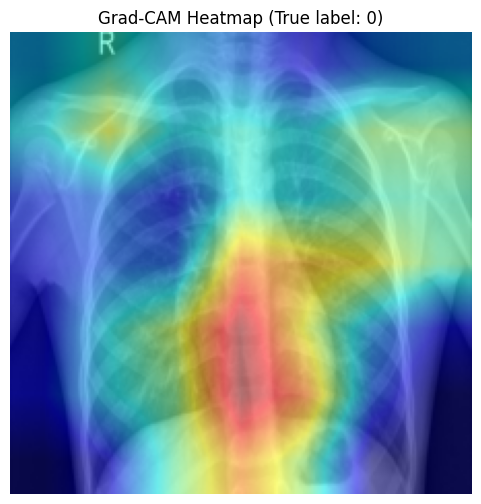

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image


model.eval()
for param in model.parameters():
    param.requires_grad = True


target_layer = model.layer4[-1].conv2


image, label = test_dataset[0]
input_tensor = image.unsqueeze(0).to(device)


cam = GradCAM(model=model, target_layers=[target_layer])


grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(label)])
grayscale_cam = grayscale_cam[0, :]  


rgb_img = np.transpose(image.numpy(), (1,2,0))
rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())


visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

plt.figure(figsize=(6,6))
plt.imshow(visualization)
plt.title(f"Grad-CAM Heatmap (True label: {label})")
plt.axis("off")
plt.show()


In [19]:
torch.save(model.state_dict(), "/content/drive/MyDrive/pneumonia_cnn.pth")
